Importando as principais bibliotecas, intalando Kymatio


In [3]:
from importlib.machinery import SourceFileLoader
#dataset = SourceFileLoader('dataset', '/content/drive/My Drive/Colab Notebooks/Libraries/dataset.py').load_module()
#models = SourceFileLoader('models','/content/drive/My Drive/Colab Notebooks/Libraries/models.py').load_module()
!pip install wget
import wget
data = wget.download('https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.01.tar.gz') 
import tarfile
data = tarfile.open(data)
data.extractall()
import numpy as np
from sklearn.metrics import accuracy_score
!pip install kymatio
import matplotlib.pyplot as plt
import pandas as pd
import os


# Preliminaries
# -------------
#
# Since we're using TensorFlow and Keras to train the model, import the
# relevant modules.

import tensorflow as tf

from tensorflow.keras import layers

# Finally, we import the `Scattering1D` class from the `kymatio.keras` package
# and the `fetch_fsdd` function from `kymatio.datasets`. The `Scattering1D`
# class is what lets us calculate the scattering transform, while the
# `fetch_fsdd` function downloads the FSDD, if needed.

#from kymatio.keras import Scattering1D
from kymatio.datasets import fetch_fsdd


Definindo as variáveis, criando um DataFrame que facilite para manipular os dados



In [4]:
from glob import glob
DIR = '/content'

LABELS = 'go stop off right left down on up yes no'.split()
NUM_CLASSES = len(LABELS)
data = []
# Get all paths inside DIR that ends with wav
wav_files = glob(os.path.join(DIR, '*/*wav'))
wav_files = [x.split(sep='/')[2] + '/' + x.split(sep='/')[3] for x in wav_files]
for e in wav_files:
  label = e.split('/')[0]
  speaker = e.split('/')[1].split('_')[0]
  if label in LABELS:
    fil = os.path.join(DIR, e)
    data.append([label,fil,speaker])
  else:
    fil = os.path.join(DIR, e)
    data.append(['unknown',fil,speaker])
df = pd.DataFrame(data,columns=['label','path','speaker'])
df.head()
#wav_files[2].split('/')[1].split('_')[0]

,label,path,speaker
0,unknown,/content/happy/f42e234b_nohash_0.wav,f42e234b
1,unknown,/content/happy/0ac15fe9_nohash_0.wav,0ac15fe9
2,unknown,/content/happy/a5d485dc_nohash_0.wav,a5d485dc
3,unknown,/content/happy/f5e5e8b0_nohash_0.wav,f5e5e8b0
4,unknown,/content/happy/ead2934a_nohash_1.wav,ead2934a


In [5]:
df['label'].value_counts()

unknown    41045
stop        2380
yes         2377
up          2375
no          2375
go          2372
on          2367
right       2367
down        2359
off         2357
left        2353
Name: label, dtype: int64

Filtrando dados 

In [6]:
probIncludeUnknown = 0.1
isUnknown = df['label']=='unknown'
df2 = df[isUnknown]
df2 = df2.sample(frac=probIncludeUnknown,replace=True,random_state=32)
df3 = df[~isUnknown]
df = pd.concat([df2,df3])


Removendo a classe "Unknown", pois aparentemente a Wavelet Scattering não lida bem com ela.

In [7]:
df3['label'].value_counts()
df = df3

In [8]:
count=[]
for e in df['speaker'].unique():
  x = df['speaker'] == e
  count.append([str(e),str(x.sum())])
count = np.array(count)


<BarContainer object of 1841 artists>

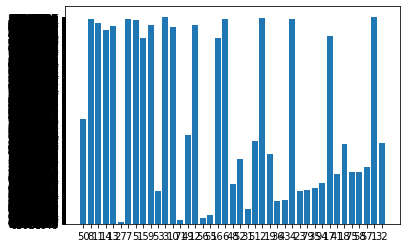

In [ ]:
import matplotlib.pyplot as plt
x = count[:,0]
y = count[:,1]
#y = count[1]
#type(x[1])
plt.bar(y,x)

In [9]:
include_speaker = []
for i in range(len(count)):
  if int(count[i,1])>=50:
    include_speaker.append(count[i,0])
include_speaker = np.array(include_speaker)

In [11]:
include_speaker_random = np.random.choice(include_speaker,10)


In [12]:
include = []
for e in df['speaker']:
  include.append(e in include_speaker_random)

df2 = df[include]

In [13]:
df2['label'].value_counts()

go       51
on       51
no       51
down     50
right    50
up       50
yes      50
stop     50
left     50
off      50
Name: label, dtype: int64

Como a Wavelet Scattering é uma técnica desenvolvida visando extrair características de datasets pequenos, inclui apenas uma fração do dataset para treinar a cada vez.

In [ ]:
dropProb = 0.450
df = df.sample(frac=dropProb)
df['label'].value_counts()

on       1113
left     1094
right    1079
no       1078
off      1077
up       1070
go       1057
down     1045
stop     1023
yes      1021
Name: label, dtype: int64

In [17]:
df = df2

Convertendo as labels para variáveis numéricas.

In [18]:
target = []
for u in df['label'].values:
  if u in LABELS:
    target.append(LABELS.index(u))
  else:
    target.append(len(LABELS)+1)
target = np.array(target)
target.shape
np.unique(target)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
if 'no' in LABELS:
  print('Entrou!')


Entrou!


In [ ]:
from distutils.dir_util import copy_tree

copy_tree('/content/drive/My Drive/Compras/lib','/usr/local/lib/python3.6/dist-packages/kymatio/scattering1d/')


['/usr/local/lib/python3.6/dist-packages/kymatio/scattering1d/filter_bank.py']

In [15]:
###############################################################################
# Pipeline setup
# --------------
# We start by specifying the dimensions of our processing pipeline along with
# some other parameters.
#
# First, we have signal length. Longer signals are truncated and shorter
# signals are zero-padded. The sampling rate is 8000 Hz, so this corresponds to
# little over a second.
from kymatio.keras import Scattering1D


T = 2 ** 14

In [ ]:
_,x = wavfile.read('/content/eight/012c8314_nohash_0.wav')
x = np.asarray(x, dtype='float')
wav_time_stch = librosa.effects.time_stretch(x,factor)
len(wav_roll)

16000

Criando a matriz com os sinais para treinamento e o target.

In [19]:
from scipy.io import wavfile
from scipy import signal
import librosa
import librosa.display

x_all = np.zeros((3*len(df['label']), T))
y_all = np.zeros(3*len(df['label']), dtype=np.uint8)
#subset = np.zeros(len(df['label']), dtype=np.uint8)
#y_all = []
#x_all = []

for k,w in enumerate(df['path']):
  y = target[k]
  #y = df['label'].values[k]
  _,x = wavfile.read(w)
  #x = signal.resample(x,2**13)
  x = np.asarray(x, dtype='float')
  x /= np.max(np.abs(x))
      # If it's too long, truncate it.
  if len(x) > T:
    x = x[:T]

  # If it's too short, zero-pad it.
  start = (T - len(x)) // 2

  #data augmentation by time stretching 

  #factor = 0.4
  #wav_time_stch = librosa.effects.time_stretch(x,factor)

  #data augmentation by time shifting the wave
  wav_roll = np.roll(x,int(16000/10))

  #data augmentation by pitch shifting
  wav_pitch_sf = librosa.effects.pitch_shift(x,16000,n_steps=-5)

  x_all[k,start:start + len(x)] = x
  x_all[k+len(df['label']),start:start+len(x)] = wav_pitch_sf
  x_all[k+2*len(df['label']),start:start+len(x)] = wav_roll
  y_all[k] = y
  y_all[k+len(df['label'])] = y
  y_all[k+2*len(df['label'])] = y

#x = np.array(x)
#y = np.array(y)



Dividir em Training Set e Testing Set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_all,y_all,test_size=0.2,random_state=42)

In [ ]:
x_all = []

In [ ]:
X_test.shape

(984, 16384)

In [21]:
# Maximum scale 2**J of the scattering transform (here, about 30 milliseconds)
# and the number of wavelets per octave.
T = 2**14
J = 13
#J = 13
Q = 14
# We need a small constant to add to the scattering coefficients before
# computing the logarithm. This prevents very large values when the scattering
# coefficients are very close to zero.
log_eps = 1e-6

In [22]:
###############################################################################
# Log-scattering layer
# --------------------
# We now create a classification model using the `Scattering1D` Keras layer.
# First, we take the input signals of length `T`.

x_in = layers.Input(shape=(T))

###############################################################################
# These are fed into the `Scattering1D` layer.

x = Scattering1D(J, Q=Q)(x_in)

###############################################################################
# Since it does not carry useful information, we remove the zeroth-order
# scattering coefficients, which are always placed in the first channel of
# the scattering transform.

x = layers.Lambda(lambda x: x[..., 1:, :])(x)

# To increase discriminability, we take the logarithm of the scattering
# coefficients (after adding a small constant to make sure nothing blows up
# when scattering coefficients are close to zero). This is known as the
# log-scattering transform.

x = layers.Lambda(lambda x: tf.math.log(tf.abs(x) + log_eps))(x)

###############################################################################
# We then average along the last dimension (time) to get a time-shift
# invariant representation.

x = layers.GlobalAveragePooling1D(data_format='channels_first')(x)

###############################################################################
# Finally, we apply batch normalization to ensure that the data is within a
# moderate range.

x = layers.BatchNormalization(axis=1)(x)

###############################################################################
# These features are then used to classify the input signal using a dense
# layer followed by a softmax activation.

x_out = layers.Dense(11, activation='softmax')(x)

###############################################################################
# Finally, we create the model and display it.

model = tf.keras.models.Model(x_in, x_out)
model.summary()


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7fdb86388ea0>. It was defined in this code:
backend.fft = FFT(lambda x: tf.signal.fft(x, name='fft1d'),
                  lambda x: tf.signal.ifft(x, name='ifft1d'),
                  lambda x: tf.math.real(tf.signal.ifft(x, name='irfft1d')),
                  lambda x: None)

This code must contain a single distinguishable lambda. To avoid this problem, define each lambda in a separate expression.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7fdb86388ea0>. It was 

In [23]:
model = model.load_weights('/content/drive/My Drive/Colab Notebooks/Kymatio/my_model_weights.index')

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


AssertionError: ignored

In [ ]:

###############################################################################
# Training the classifier
# -----------------------
# Having set up the model, we attach an Adam optimizer and a cross-entropy
# loss function.

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

###############################################################################
# We then train the model using `model.fit`. The training data is given by
# those indices satisfying `subset == 0`.

model.fit(X_train, y_train, epochs=200,
          batch_size=64, validation_split=0.2)

###############################################################################
# Finally, we evaluate the model on the held-out test data. These are given by
# the indices `subset == 1`.

model.evaluate(X_test, y_test, verbose=1)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16384)]           0         
_________________________________________________________________
scattering1d_3 (Scattering1D (None, 1096, 2)           0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 1095, 2)           0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 1095, 2)           0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 1095)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1095)              4380      
_________________________________________________________________
dense_2 (Dense)              (None, 11)               

[0.8672488331794739, 0.7649006843566895]

In [ ]:
y_all

array([5, 5, 5, ..., 0, 0, 0], dtype=uint8)

In [ ]:
y.shape

(64727,)

In [ ]:
###############################################################################
# Pipeline setup
# --------------
# We start by specifying the dimensions of our processing pipeline along with
# some other parameters.
#
# First, we have signal length. Longer signals are truncated and shorter
# signals are zero-padded. The sampling rate is 8000 Hz, so this corresponds to
# little over a second.

T = 2 ** 14


In [ ]:
# Maximum scale 2**J of the scattering transform (here, about 30 milliseconds)
# and the number of wavelets per octave.
J = 8
Q = 12

In [ ]:
# We need a small constant to add to the scattering coefficients before
# computing the logarithm. This prevents very large values when the scattering
# coefficients are very close to zero.
log_eps = 1e-6

In [ ]:
info_data = fetch_fsdd()
files = info_data['files']
path_dataset = info_data['path_dataset']


teste = []
for k,w in enumerate(df['path']):
  teste.append([k,w])
teste

In [ ]:
_, x = wavfile.read('/content/eight/012c8314_nohash_0.wav')
x = np.asarray(x, dtype='float')
x /= np.max(np.abs(x))

resample = 

SyntaxError: ignored

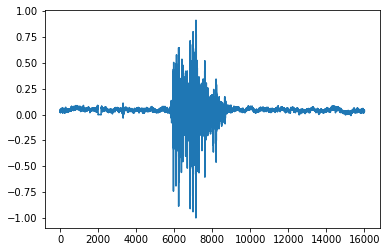

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x)

In [ ]:
# If it's too long, truncate it.
if len(x) > T:
    x = x[:T]

    # If it's too short, zero-pad it.
    start = (T - len(x)) // 2

    x_all[k,start:start + len(x)] = x
    y_all[k] = y

NameError: ignored

In [ ]:
###############################################################################
# Log-scattering layer
# --------------------
# We now create a classification model using the `Scattering1D` Keras layer.
# First, we take the input signals of length `T`.

x_in = layers.Input(shape=(T))

###############################################################################
# These are fed into the `Scattering1D` layer.

x = Scattering1D(J, Q=Q)(x_in)

###############################################################################

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f2d295a7268>. It was defined in this code:
backend.fft = FFT(lambda x: tf.signal.fft(x, name='fft1d'),
                  lambda x: tf.signal.ifft(x, name='ifft1d'),
                  lambda x: tf.math.real(tf.signal.ifft(x, name='irfft1d')),
                  lambda x: None)

This code must contain a single distinguishable lambda. To avoid this problem, define each lambda in a separate expression.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f2d295a7268>. It was 

In [ ]:
x

<tf.Tensor 'scattering1d/Reshape_674:0' shape=(None, 337, 64) dtype=float32>

In [ ]:
###############################################################################
# Loading the data
# ----------------
# Once the parameter are set, we can start loading the data into a format that
# can be fed into the scattering transform and then a logistic regression
# classifier.
#
# We first download the dataset. If it's already downloaded, `fetch_fsdd` will
# simply return the information corresponding to the dataset that's already
# on disk.

from scipy.io import wavfile

info_data = fetch_fsdd()
files = info_data['files']
path_dataset = info_data['path_dataset']

###############################################################################
# Set up NumPy arrays to hold the audio signals (`x_all`), the labels
# (`y_all`), and whether the signal is in the train or test set (`subset`).

x_all = np.zeros((len(files), T))
y_all = np.zeros(len(files), dtype=np.uint8)
subset = np.zeros(len(files), dtype=np.uint8)

###############################################################################
# For each file in the dataset, we extract its label `y` and its index from the
# filename. If the index is between 0 and 4, it is placed in the test set, while
# files with larger indices are used for training. The actual signals are
# normalized to have maximum amplitude one, and are truncated or zero-padded
# to the desired length `T`. They are then stored in the `x_all` array while
# their labels are in `y_all`.

for k, f in enumerate(files):
    basename = f.split('.')[0]

    # Get label (0-9) of recording.
    y = int(basename.split('_')[0])

    # Index larger than 5 gets assigned to training set.
    if int(basename.split('_')[2]) >= 5:
        subset[k] = 0
    else:
        subset[k] = 1

    # Load the audio signal and normalize it.
    _, x = wavfile.read(os.path.join(path_dataset, f))
    x = np.asarray(x, dtype='float')
    x /= np.max(np.abs(x))

    # If it's too long, truncate it.
    if len(x) > T:
        x = x[:T]

    # If it's too short, zero-pad it.
    start = (T - len(x)) // 2

    x_all[k,start:start + len(x)] = x
    y_all[k] = y



In [ ]:
x_all.shape
np.unique(y_all)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
###############################################################################
# Log-scattering layer
# --------------------
# We now create a classification model using the `Scattering1D` Keras layer.
# First, we take the input signals of length `T`.

x_in = layers.Input(shape=(T))

###############################################################################
# These are fed into the `Scattering1D` layer.

x = Scattering1D(J, Q=Q)(x_in)


In [ ]:
Q

24

In [ ]:
###############################################################################
# Since it does not carry useful information, we remove the zeroth-order
# scattering coefficients, which are always placed in the first channel of
# the scattering transform.

x = layers.Lambda(lambda x: x[..., 1:, :])(x)

# To increase discriminability, we take the logarithm of the scattering
# coefficients (after adding a small constant to make sure nothing blows up
# when scattering coefficients are close to zero). This is known as the
# log-scattering transform.

x = layers.Lambda(lambda x: tf.math.log(tf.abs(x) + log_eps))(x)

###############################################################################
# We then average along the last dimension (time) to get a time-shift
# invariant representation.

x = layers.GlobalAveragePooling1D(data_format='channels_first')(x)

###############################################################################
# Finally, we apply batch normalization to ensure that the data is within a
# moderate range.

x = layers.BatchNormalization(axis=1)(x)

###############################################################################
# These features are then used to classify the input signal using a dense
# layer followed by a softmax activation.

x_out = layers.Dense(10, activation='softmax')(x)

###############################################################################
# Finally, we create the model and display it.

model = tf.keras.models.Model(x_in, x_out)
model.summary()

###############################################################################
# Training the classifier
# -----------------------
# Having set up the model, we attach an Adam optimizer and a cross-entropy
# loss function.

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

###############################################################################
# We then train the model using `model.fit`. The training data is given by
# those indices satisfying `subset == 0`.

model.fit(x_all[subset == 0], y_all[subset == 0], epochs=50,
          batch_size=64, validation_split=0.2)

###############################################################################
# Finally, we evaluate the model on the held-out test data. These are given by
# the indices `subset == 1`.

model.evaluate(x_all[subset == 1], y_all[subset == 1], verbose=2)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16384)]           0         
_________________________________________________________________
scattering1d_1 (Scattering1D (None, 616, 64)           0         
_________________________________________________________________
lambda (Lambda)              (None, 615, 64)           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 615, 64)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 615)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 615)               2460      
_________________________________________________________________
dense (Dense)                (None, 10)               

[0.16229890286922455, 0.9480000138282776]

In [ ]:
import os
import numpy as np
import pandas as pd
import random
    
from glob import glob

from scipy.io import wavfile
from scipy import signal

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from keras.utils import to_categorical


#pca = PCA(n_components=30)   


class DatasetGenerator_CWT():
    def __init__(self, label_set, 
                 sample_rate=16000):
        
        self.label_set = label_set
        self.sample_rate = sample_rate
            
    # Covert string to numerical classes              
    def text_to_labels(self, text):
        return self.label_set.index(text)
    
    # Reverse translation of numerical classes back to characters
    def labels_to_text(self, labels):
        return self.label_set[labels]               
        
    def load_data(self, DIR):

        # Get all paths inside DIR that ends with wav
        wav_files = glob(os.path.join(DIR, '*/*wav'))
        wav_files = [x.split(sep='/')[2] + '/' + x.split(sep='/')[3] for x in wav_files]
        
        # Loop over files to get samples
        data = []
        for e in wav_files:
            
            label, name = e.split('/')
            if label in self.label_set:
                label_id = self.text_to_labels(label)
                fle = os.path.join(DIR, e)
                
                sample = (label, label_id, name, fle)
                data.append(sample)
            else 

            
        # Data Frames with samples' labels and paths     
        df = pd.DataFrame(data, columns = ['label', 'label_id', 'user_id', 'wav_file'])
        
        self.df = df
        
        return self.df

    def apply_train_test_split(self, test_size, random_state):
        
        self.df_train, self.df_test = train_test_split(self.df, 
                                                       test_size=test_size,
                                                       random_state=random_state)
        
    def apply_train_val_split(self, val_size, random_state):
        
        self.df_train, self.df_val = train_test_split(self.df_train, 
                                                      test_size=val_size, 
                                                      random_state=random_state)
        
    def read_wav_file(self, x):
        # Read wavfile using scipy wavfile.read
        _, wav = wavfile.read(x) 
        # Normalize
        wav = wav.astype(np.float32) / np.iinfo(np.int16).max
            
        return wav
    def process_wav_file(self, x, threshold_freq=5500, eps=1e-10):
        # Read wav file to array
        wav = self.read_wav_file(x)
        # Sample rate
        L = self.sample_rate
        # If longer then randomly truncate
        if len(wav) > L:
            i = np.random.randint(0, len(wav) - L)
            wav = wav[i:(i+L)]  
        # If shorter then randomly add silence
        elif len(wav) < L:
            rem_len = L - len(wav)
            silence_part = np.random.randint(-100,100,16000).astype(np.float32) / np.iinfo(np.int16).max
            j = np.random.randint(0, rem_len)
            silence_part_left  = silence_part[0:j]
            silence_part_right = silence_part[j:rem_len]
            wav = np.concatenate([silence_part_left, wav, silence_part_right])
        # Create spectrogram using continous wavelet transform (time-frequency representation)
        times,dt = np.linspace(0, 1, 16000, retstep=True)
        fs = 1/dt
        freqs = np.linspace(1, fs/2, 98)
        w = 6
        widths = w*fs / (2*freqs*np.pi)
        spec = signal.cwt(wav, signal.morlet2, widths, w=w)
        # Cut high frequencies
        #if threshold_freq is not None:
        #    spec = spec[freqs <= threshold_freq,:]
        #    freqs = freqs[freqs <= threshold_freq]
        # Log spectrogram
        amp = np.log(np.abs(spec)+eps)
        pca_test = pca.fit(amp)
        pca_data = pca.transform(amp)
        amp = pca_data
        #return amp 
        return np.expand_dims(amp, axis=2) 

    def generator(self, batch_size, mode):
        while True:
            # Depending on mode select DataFrame with paths
            if mode == 'train':
                df = self.df_train 
                ids = random.sample(range(df.shape[0]), df.shape[0])
            elif mode == 'val':
                df = self.df_val
                ids = list(range(df.shape[0]))
            elif mode == 'test':
                df = self.df_test
                ids = list(range(df.shape[0]))
            else:
                raise ValueError('The mode should be either train, val or test.')
                
            # Create batches (for training data the batches are randomly permuted)
            for start in range(0, len(ids), batch_size):
                X_batch = []
                if mode != 'test': 
                    y_batch = []
                end = min(start + batch_size, len(ids))
                i_batch = ids[start:end]
                for i in i_batch:
                    X_batch.append(self.process_wav_file(df.wav_file.values[i]))
                    if mode != 'test':
                        y_batch.append(df.label_id.values[i])
                X_batch = np.array(X_batch)

                if mode != 'test':
                    y_batch = to_categorical(y_batch, num_classes = len(self.label_set))
                    yield (X_batch, y_batch)
                else:
                    yield X_batch

In [ ]:
import numpy as np
import math
import warnings
from scipy.fftpack import ifft

def adaptive_choice_P(sigma, eps=1e-7):
    """
    Adaptive choice of the value of the number of periods in the frequency
    domain used to compute the Fourier transform of a Morlet wavelet.

    This function considers a Morlet wavelet defined as the sum
    of
    * a Gabor term hat psi(omega) = hat g_{sigma}(omega - xi)
    where 0 < xi < 1 is some frequency and g_{sigma} is
    the Gaussian window defined in Fourier by
    hat g_{sigma}(omega) = e^{-omega^2/(2 sigma^2)}
    * a low pass term \\hat \\phi which is proportional to \\hat g_{\\sigma}.

    If \\sigma is too large, then these formula will lead to discontinuities
    in the frequency interval [0, 1] (which is the interval used by numpy.fft).
    We therefore choose a larger integer P >= 1 such that at the boundaries
    of the Fourier transform of both filters on the interval [1-P, P], the
    magnitude of the entries is below the required machine precision.
    Mathematically, this means we would need P to satisfy the relations:

    |\\hat \\psi(P)| <= eps and |\\hat \\phi(1-P)| <= eps

    Since 0 <= xi <= 1, the latter implies the former. Hence the formula which
    is easily derived using the explicit formula for g_{\\sigma} in Fourier.

    Parameters
    ----------
    sigma: float
        Positive number controlling the bandwidth of the filters
    eps : float, optional
        Positive number containing required precision. Defaults to 1e-7

    Returns
    -------
    P : int
        integer controlling the number of periods used to ensure the
        periodicity of the final Morlet filter in the frequency interval
        [0, 1[. The value of P will lead to the use of the frequency
        interval [1-P, P[, so that there are 2*P - 1 periods.
    """
    val = math.sqrt(-2 * (sigma**2) * math.log(eps))
    P = int(math.ceil(val + 1))
    return P


def periodize_filter_fourier(h_f, nperiods=1):
    """
    Computes a periodization of a filter provided in the Fourier domain.

    Parameters
    ----------
    h_f : array_like
        complex numpy array of shape (N*n_periods,)
    n_periods: int, optional
        Number of periods which should be used to periodize

    Returns
    -------
    v_f : array_like
        complex numpy array of size (N,), which is a periodization of
        h_f as described in the formula:
        v_f[k] = sum_{i=0}^{n_periods - 1} h_f[i * N + k]
    """
    N = h_f.shape[0] // nperiods
    v_f = h_f.reshape(nperiods, N).mean(axis=0)
    return v_f


def morlet_1d(N, xi, sigma, normalize='l1', P_max=5, eps=1e-7):
    """
    Computes the Fourier transform of a Morlet filter.

    A Morlet filter is the sum of a Gabor filter and a low-pass filter
    to ensure that the sum has exactly zero mean in the temporal domain.
    It is defined by the following formula in time:
    psi(t) = g_{sigma}(t) (e^{i xi t} - beta)
    where g_{sigma} is a Gaussian envelope, xi is a frequency and beta is
    the cancelling parameter.

    Parameters
    ----------
    N : int
        size of the temporal support
    xi : float
        central frequency (in [0, 1])
    sigma : float
        bandwidth parameter
    normalize : string, optional
        normalization types for the filters. Defaults to 'l1'.
        Supported normalizations are 'l1' and 'l2' (understood in time domain).
    P_max: int, optional
        integer controlling the maximal number of periods to use to ensure
        the periodicity of the Fourier transform. (At most 2*P_max - 1 periods
        are used, to ensure an equal distribution around 0.5). Defaults to 5
        Should be >= 1
    eps : float
        required machine precision (to choose the adequate P)

    Returns
    -------
    morlet_f : array_like
        numpy array of size (N,) containing the Fourier transform of the Morlet
        filter at the frequencies given by np.fft.fftfreq(N).
    """
    if type(P_max) != int:
        raise ValueError('P_max should be an int, got {}'.format(type(P_max)))
    if P_max < 1:
        raise ValueError('P_max should be non-negative, got {}'.format(P_max))
    # Find the adequate value of P
    P = min(adaptive_choice_P(sigma, eps=eps), P_max)
    assert P >= 1
    # Define the frequencies over [1-P, P[
    freqs = np.arange((1 - P) * N, P * N, dtype=float) / float(N)
    if P == 1:
        # in this case, make sure that there is continuity around 0
        # by using the interval [-0.5, 0.5]
        freqs_low = np.fft.fftfreq(N)
    elif P > 1:
        freqs_low = freqs
    # define the gabor at freq xi and the low-pass, both of width sigma
    gabor_f = np.exp(-(freqs - xi)**2 / (2 * sigma**2))
    low_pass_f = np.exp(-(freqs_low**2) / (2 * sigma**2))
    # discretize in signal <=> periodize in Fourier
    gabor_f = periodize_filter_fourier(gabor_f, nperiods=2 * P - 1)
    low_pass_f = periodize_filter_fourier(low_pass_f, nperiods=2 * P - 1)
    # find the summation factor to ensure that morlet_f[0] = 0.
    kappa = gabor_f[0] / low_pass_f[0]
    morlet_f = gabor_f - kappa * low_pass_f
    # normalize the Morlet if necessary
    morlet_f *= get_normalizing_factor(morlet_f, normalize=normalize)
    return morlet_f


def get_normalizing_factor(h_f, normalize='l1'):
    """
    Computes the desired normalization factor for a filter defined in Fourier.

    Parameters
    ----------
    h_f : array_like
        numpy vector containing the Fourier transform of a filter
    normalized : string, optional
        desired normalization type, either 'l1' or 'l2'. Defaults to 'l1'.

    Returns
    -------
    norm_factor : float
        such that h_f * norm_factor is the adequately normalized vector.
    """
    h_real = ifft(h_f)
    if normalize == 'l1':
        norm_factor = 1. / (np.abs(h_real).sum())
    elif normalize == 'l2':
        norm_factor = 1. / np.sqrt((np.abs(h_real)**2).sum())
    else:
        raise ValueError("Supported normalizations only include 'l1' and 'l2'")
    return norm_factor


def gauss_1d(N, sigma, normalize='l1', P_max=5, eps=1e-7):
    """
    Computes the Fourier transform of a low pass gaussian window.

    \\hat g_{\\sigma}(\\omega) = e^{-\\omega^2 / 2 \\sigma^2}

    Parameters
    ----------
    N : int
        size of the temporal support
    sigma : float
        bandwidth parameter
    normalize : string, optional
        normalization types for the filters. Defaults to 'l1'
        Supported normalizations are 'l1' and 'l2' (understood in time domain).
    P_max : int, optional
        integer controlling the maximal number of periods to use to ensure
        the periodicity of the Fourier transform. (At most 2*P_max - 1 periods
        are used, to ensure an equal distribution around 0.5). Defaults to 5
        Should be >= 1
    eps : float, optional
        required machine precision (to choose the adequate P)

    Returns
    -------
    g_f : array_like
        numpy array of size (N,) containing the Fourier transform of the
        filter (with the frequencies in the np.fft.fftfreq convention).
    """
    # Find the adequate value of P
    if type(P_max) != int:
        raise ValueError('P_max should be an int, got {}'.format(type(P_max)))
    if P_max < 1:
        raise ValueError('P_max should be non-negative, got {}'.format(P_max))
    P = min(adaptive_choice_P(sigma, eps=eps), P_max)
    assert P >= 1
    # switch cases
    if P == 1:
        freqs_low = np.fft.fftfreq(N)
    elif P > 1:
        freqs_low = np.arange((1 - P) * N, P * N, dtype=float) / float(N)
    # define the low pass
    g_f = np.exp(-freqs_low**2 / (2 * sigma**2))
    # periodize it
    g_f = periodize_filter_fourier(g_f, nperiods=2 * P - 1)
    # normalize the signal
    g_f *= get_normalizing_factor(g_f, normalize=normalize)
    # return the Fourier transform
    return g_f


def compute_sigma_psi(xi, Q, r=math.sqrt(0.5)):
    """
    Computes the frequential width sigma for a Morlet filter of frequency xi
    belonging to a family with Q wavelets.

    The frequential width is adapted so that the intersection of the
    frequency responses of the next filter occurs at a r-bandwidth specified
    by r, to ensure a correct coverage of the whole frequency axis.

    Parameters
    ----------
    xi : float
        frequency of the filter in [0, 1]
    Q : int
        number of filters per octave, Q is an integer >= 1
    r : float, optional
        Positive parameter defining the bandwidth to use.
        Should be < 1. We recommend keeping the default value.
        The larger r, the larger the filters in frequency domain.

    Returns
    -------
    sigma : float
        frequential width of the Morlet wavelet.

    Refs
    ----
    Convolutional operators in the time-frequency domain, V. Lostanlen,
    PhD Thesis, 2017
    https://tel.archives-ouvertes.fr/tel-01559667
    """
    factor = 1. / math.pow(2, 1. / Q)
    term1 = (1 - factor) / (1 + factor)
    term2 = 1. / math.sqrt(2 * math.log(1. / r))
    return xi * term1 * term2


def compute_temporal_support(h_f, criterion_amplitude=1e-3):
    """
    Computes the (half) temporal support of a family of centered,
    symmetric filters h provided in the Fourier domain

    This function computes the support T which is the smallest integer
    such that for all signals x and all filters h,

    \\| x \\conv h - x \\conv h_{[-T, T]} \\|_{\\infty} \\leq \\epsilon
        \\| x \\|_{\\infty}  (1)

    where 0<\\epsilon<1 is an acceptable error, and h_{[-T, T]} denotes the
    filter h whose support is restricted in the interval [-T, T]

    The resulting value T used to pad the signals to avoid boundary effects
    and numerical errors.

    If the support is too small, no such T might exist.
    In this case, T is defined as the half of the support of h, and a
    UserWarning is raised.

    Parameters
    ----------
    h_f : array_like
        a numpy array of size batch x time, where each row contains the
        Fourier transform of a filter which is centered and whose absolute
        value is symmetric
    criterion_amplitude : float, optional
        value \\epsilon controlling the numerical
        error. The larger criterion_amplitude, the smaller the temporal
        support and the larger the numerical error. Defaults to 1e-3

    Returns
    -------
    t_max : int
        temporal support which ensures (1) for all rows of h_f

    """
    h = ifft(h_f, axis=1)
    half_support = h.shape[1] // 2
    # compute ||h - h_[-T, T]||_1
    l1_residual = np.fliplr(
        np.cumsum(np.fliplr(np.abs(h)[:, :half_support]), axis=1))
    # find the first point above criterion_amplitude
    if np.any(np.max(l1_residual, axis=0) <= criterion_amplitude):
        # if it is possible
        T = np.min(
            np.where(np.max(l1_residual, axis=0) <= criterion_amplitude)[0])\
            + 1
    else:
        # if there is none:
        T = half_support
        # Raise a warning to say that there will be border effects
        warnings.warn('Signal support is too small to avoid border effects')
    return T


def get_max_dyadic_subsampling(xi, sigma, alpha=5.):
    """
    Computes the maximal dyadic subsampling which is possible for a Gabor
    filter of frequency xi and width sigma

    Finds the maximal integer j such that:
    omega_0 < 2^{-(j + 1)}
    where omega_0 is the boundary of the filter, defined as
    omega_0 = xi + alpha * sigma

    This ensures that the filter can be subsampled by a factor 2^j without
    aliasing.

    We use the same formula for Gabor and Morlet filters.

    Parameters
    ----------
    xi : float
        frequency of the filter in [0, 1]
    sigma : float
        frequential width of the filter
    alpha : float, optional
        parameter controlling the error done in the aliasing.
        The larger alpha, the smaller the error. Defaults to 5.

    Returns
    -------
    j : int
        integer such that 2^j is the maximal subsampling accepted by the
        Gabor filter without aliasing.
    """
    upper_bound = min(xi + alpha * sigma, 0.5)
    j = math.floor(-math.log2(upper_bound)) - 1
    j = int(j)
    return j


def move_one_dyadic_step(cv, Q, alpha=5.):
    """
    Computes the parameters of the next wavelet on the low frequency side,
    based on the parameters of the current wavelet.

    This function is used in the loop defining all the filters, starting
    at the wavelet frequency and then going to the low frequencies by
    dyadic steps. This makes the loop in compute_params_filterbank much
    simpler to read.

    The steps are defined as:
    xi_{n+1} = 2^{-1/Q} xi_n
    sigma_{n+1} = 2^{-1/Q} sigma_n

    Parameters
    ----------
    cv : dictionary
        stands for current_value. Is a dictionary with keys:
        *'key': a tuple (j, n) where n is a counter and j is the maximal
            dyadic subsampling accepted by this wavelet.
        *'xi': central frequency of the wavelet
        *'sigma': width of the wavelet
    Q : int
        number of wavelets per octave. Controls the relationship between
        the frequency and width of the current wavelet and the next wavelet.
    alpha : float, optional
        tolerance parameter for the aliasing. The larger alpha,
        the more conservative the algorithm is. Defaults to 5.

    Returns
    -------
    new_cv : dictionary
        a dictionary with the same keys as the ones listed for cv,
        whose values are updated
    """
    factor = 1. / math.pow(2., 1. / Q)
    n = cv['key']
    new_cv = {'xi': cv['xi'] * factor, 'sigma': cv['sigma'] * factor}
    # compute the new j
    new_cv['j'] = get_max_dyadic_subsampling(new_cv['xi'], new_cv['sigma'], alpha=alpha)
    new_cv['key'] = n + 1
    return new_cv


def compute_xi_max(Q):
    """
    Computes the maximal xi to use for the Morlet family, depending on Q.

    Parameters
    ----------
    Q : int
        number of wavelets per octave (integer >= 1)

    Returns
    -------
    xi_max : float
        largest frequency of the wavelet frame.
    """
    xi_max = max(1. / (1. + math.pow(2., 3. / Q)), 0.35)
    return xi_max


def compute_params_filterbank(sigma_low, Q, r_psi=math.sqrt(0.5), alpha=5.):
    """
    Computes the parameters of a Morlet wavelet filterbank.

    This family is defined by constant ratios between the frequencies and
    width of adjacent filters, up to a minimum frequency where the frequencies
    are translated.
    This ensures that the low-pass filter has the largest temporal support
    among all filters, while preserving the coverage of the whole frequency
    axis.

    The keys of the dictionaries are tuples of integers (j, n) where n is a
    counter (starting at 0 for the highest frequency filter) and j is the
    maximal dyadic subsampling accepted by this filter.

    Parameters
    ----------
    sigma_low : float
        frequential width of the low-pass filter. This acts as a
        lower-bound on the frequential widths of the band-pass filters,
        so as to ensure that the low-pass filter has the largest temporal
        support among all filters.
    Q : int
        number of wavelets per octave.
    r_psi : float, optional
        Should be >0 and <1. Controls the redundancy of the filters
        (the larger r_psi, the larger the overlap between adjacent wavelets).
        Defaults to sqrt(0.5).
    alpha : float, optional
        tolerance factor for the aliasing after subsampling.
        The larger alpha, the more conservative the value of maximal
        subsampling is. Defaults to 5.

    Returns
    -------
    xi : dictionary
        dictionary containing the central frequencies of the wavelets.
    sigma : dictionary
        dictionary containing the frequential widths of the wavelets.

    Refs
    ----
    Convolutional operators in the time-frequency domain, 2.1.3, V. Lostanlen,
    PhD Thesis, 2017
    https://tel.archives-ouvertes.fr/tel-01559667
    """
    xi_max = compute_xi_max(Q)
    sigma_max = compute_sigma_psi(xi_max, Q, r=r_psi)

    xi = []
    sigma = []
    j = []

    if sigma_max <= sigma_low:
        # in this exceptional case, we will not go through the loop, so
        # we directly assign
        last_xi = sigma_max
    else:
        # fill all the dyadic wavelets as long as possible
        current = {'key': 0, 'j': 0, 'xi': xi_max, 'sigma': sigma_max}
        while current['sigma'] > sigma_low:  # while we can attribute something
            xi.append(current['xi'])
            sigma.append(current['sigma'])
            j.append(current['j'])
            current = move_one_dyadic_step(current, Q, alpha=alpha)
        # get the last key
        last_xi = xi[-1]
    # fill num_interm wavelets between last_xi and 0, both excluded
    num_intermediate = Q - 1
    for q in range(1, num_intermediate + 1):
        factor = (num_intermediate + 1. - q) / (num_intermediate + 1.)
        new_xi = factor * last_xi
        new_sigma = sigma_low
        xi.append(new_xi)
        sigma.append(new_sigma)
        j.append(get_max_dyadic_subsampling(new_xi, new_sigma, alpha=alpha))
    # return results
    return xi, sigma, j


def calibrate_scattering_filters(J, Q, r_psi=math.sqrt(0.5), sigma0=0.1,
                                 alpha=5.):
    """
    Calibrates the parameters of the filters used at the 1st and 2nd orders
    of the scattering transform.

    These filterbanks share the same low-pass filterbank, but use a
    different Q: Q_1 = Q and Q_2 = 1.

    The dictionaries for the band-pass filters have keys which are 2-tuples
    of the type (j, n), where n is an integer >=0 counting the filters (for
    identification purposes) and j is an integer >= 0 denoting the maximal
    subsampling 2**j which can be performed on a signal convolved with this
    filter without aliasing.

    Parameters
    ----------
    J : int
        maximal scale of the scattering (controls the number of wavelets)
    Q : int
        number of wavelets per octave for the first order
    r_psi : float, optional
        Should be >0 and <1. Controls the redundancy of the filters
        (the larger r_psi, the larger the overlap between adjacent wavelets).
        Defaults to sqrt(0.5)
    sigma0 : float, optional
        frequential width of the low-pass filter at scale J=0
        (the subsequent widths are defined by sigma_J = sigma0 / 2^J).
        Defaults to 1e-1
    alpha : float, optional
        tolerance factor for the aliasing after subsampling.
        The larger alpha, the more conservative the value of maximal
        subsampling is. Defaults to 5.

    Returns
    -------
    sigma_low : float
        frequential width of the low-pass filter
    xi1 : dictionary
        dictionary containing the center frequencies of the first order
        filters. See above for a decsription of the keys.
    sigma1 : dictionary
        dictionary containing the frequential width of the first order
        filters. See above for a description of the keys.
    xi2 : dictionary
        dictionary containing the center frequencies of the second order
        filters. See above for a decsription of the keys.
    sigma2 : dictionary
        dictionary containing the frequential width of the second order
        filters. See above for a description of the keys.
    """
    if Q < 1:
        raise ValueError('Q should always be >= 1, got {}'.format(Q))
    sigma_low = sigma0 / math.pow(2, J)  # width of the low pass
    xi1, sigma1, j1 = compute_params_filterbank(sigma_low, Q, r_psi=r_psi,
                                            alpha=alpha)
    xi2, sigma2, j2 = compute_params_filterbank(sigma_low, 1, r_psi=r_psi,
                                            alpha=alpha)
    return sigma_low, xi1, sigma1, j1, xi2, sigma2, j2


def scattering_filter_factory(J_support, J_scattering, Q, r_psi=math.sqrt(0.5),
                              criterion_amplitude=1e-3, normalize='l1',
                              max_subsampling=None, sigma0=0.1, alpha=5.,
                              P_max=5, eps=1e-7, **kwargs):
    """
    Builds in Fourier the Morlet filters used for the scattering transform.

    Each single filter is provided as a dictionary with the following keys:
    * 'xi': central frequency, defaults to 0 for low-pass filters.
    * 'sigma': frequential width
    * k where k is an integer bounded below by 0. The maximal value for k
        depends on the type of filter, it is dynamically chosen depending
        on max_subsampling and the characteristics of the filters.
        Each value for k is an array (or tensor) of size 2**(J_support - k)
        containing the Fourier transform of the filter after subsampling by
        2**k

    Parameters
    ----------
    J_support : int
        2**J_support is the desired support size of the filters
    J_scattering : int
        parameter for the scattering transform (2**J_scattering
        corresponds to the averaging support of the low-pass filter)
    Q : int
        number of wavelets per octave at the first order. For audio signals,
        a value Q >= 12 is recommended in order to separate partials.
    r_psi : float, optional
        Should be >0 and <1. Controls the redundancy of the filters
        (the larger r_psi, the larger the overlap between adjacent wavelets).
        Defaults to sqrt(0.5).
    criterion_amplitude : float, optional
        Represents the numerical error which is allowed to be lost after
        convolution and padding. Defaults to 1e-3.
    normalize : string, optional
        Normalization convention for the filters (in the
        temporal domain). Supported values include 'l1' and 'l2'; a ValueError
        is raised otherwise. Defaults to 'l1'.
    max_subsampling: int or None, optional
        maximal dyadic subsampling to compute, in order
        to save computation time if it is not required. Defaults to None, in
        which case this value is dynamically adjusted depending on the filters.
    sigma0 : float, optional
        parameter controlling the frequential width of the
        low-pass filter at J_scattering=0; at a an absolute J_scattering, it
        is equal to sigma0 / 2**J_scattering. Defaults to 1e-1
    alpha : float, optional
        tolerance factor for the aliasing after subsampling.
        The larger alpha, the more conservative the value of maximal
        subsampling is. Defaults to 5.
    P_max : int, optional
        maximal number of periods to use to make sure that the Fourier
        transform of the filters is periodic. P_max = 5 is more than enough for
        double precision. Defaults to 5. Should be >= 1
    eps : float, optional
        required machine precision for the periodization (single
        floating point is enough for deep learning applications).
        Defaults to 1e-7

    Returns
    -------
    phi_f : dictionary
        a dictionary containing the low-pass filter at all possible
        subsamplings. See above for a description of the dictionary structure.
        The possible subsamplings are controlled by the inputs they can
        receive, which correspond to the subsamplings performed on top of the
        1st and 2nd order transforms.
    psi1_f : dictionary
        a dictionary containing the band-pass filters of the 1st order,
        only for the base resolution as no subsampling is used in the
        scattering tree.
        Each value corresponds to a dictionary for a single filter, see above
        for an exact description.
        The keys of this dictionary are of the type (j, n) where n is an
        integer counting the filters and j the maximal dyadic subsampling
        which can be performed on top of the filter without aliasing.
    psi2_f : dictionary
        a dictionary containing the band-pass filters of the 2nd order
        at all possible subsamplings. The subsamplings are determined by the
        input they can receive, which depends on the scattering tree.
        Each value corresponds to a dictionary for a single filter, see above
        for an exact description.
        The keys of this dictionary are of th etype (j, n) where n is an
        integer counting the filters and j is the maximal dyadic subsampling
        which can be performed on top of this filter without aliasing.
    t_max_phi : int
        temporal size to use to pad the signal on the right and on the
        left by making at most criterion_amplitude error. Assumes that the
        temporal support of the low-pass filter is larger than all filters.

    Refs
    ----
    Convolutional operators in the time-frequency domain, V. Lostanlen,
    PhD Thesis, 2017
    https://tel.archives-ouvertes.fr/tel-01559667
    """
    # compute the spectral parameters of the filters
    sigma_low, xi1, sigma1, j1s, xi2, sigma2, j2s = calibrate_scattering_filters(
        J_scattering, Q, r_psi=r_psi, sigma0=sigma0, alpha=alpha)

    # instantiate the dictionaries which will contain the filters
    phi_f = {}
    psi1_f = []
    psi2_f = []

    # compute the band-pass filters of the second order,
    # which can take as input a subsampled
    for (n2, j2) in enumerate(j2s):
        # compute the current value for the max_subsampling,
        # which depends on the input it can accept.
        if max_subsampling is None:
            possible_subsamplings_after_order1 = [
                j1 for j1 in j1s if j2 > j1]
            if len(possible_subsamplings_after_order1) > 0:
                max_sub_psi2 = max(possible_subsamplings_after_order1)
            else:
                max_sub_psi2 = 0
        else:
            max_sub_psi2 = max_subsampling
        # We first compute the filter without subsampling
        T = 2**J_support

        psi_f = {}
        psi_f[0] = morlet_1d(
            T, xi2[n2], sigma2[n2], normalize=normalize, P_max=P_max,
            eps=eps)
        # compute the filter after subsampling at all other subsamplings
        # which might be received by the network, based on this first filter
        for subsampling in range(1, max_sub_psi2 + 1):
            factor_subsampling = 2**subsampling
            psi_f[subsampling] = periodize_filter_fourier(
                psi_f[0], nperiods=factor_subsampling)
        psi2_f.append(psi_f)

    # for the 1st order filters, the input is not subsampled so we
    # can only compute them with T=2**J_support
    for (n1, j1) in enumerate(j1s):
        T = 2**J_support
        psi1_f.append({0: morlet_1d(
            T, xi1[n1], sigma1[n1], normalize=normalize,
            P_max=P_max, eps=eps)})

    # compute the low-pass filters phi
    # Determine the maximal subsampling for phi, which depends on the
    # input it can accept (both 1st and 2nd order)
    if max_subsampling is None:
        max_subsampling_after_psi1 = max(j1s)
        max_subsampling_after_psi2 = max(j2s)
        max_sub_phi = max(max_subsampling_after_psi1,
                          max_subsampling_after_psi2)
    else:
        max_sub_phi = max_subsampling

    # compute the filters at all possible subsamplings
    phi_f[0] = gauss_1d(T, sigma_low, P_max=P_max, eps=eps)
    for subsampling in range(1, max_sub_phi + 1):
        factor_subsampling = 2**subsampling
        # compute the low_pass filter
        phi_f[subsampling] = periodize_filter_fourier(
            phi_f[0], nperiods=factor_subsampling)

    # Embed the meta information within the filters
    for (n1, j1) in enumerate(j1s):
        psi1_f[n1]['xi'] = xi1[n1]
        psi1_f[n1]['sigma'] = sigma1[n1]
        psi1_f[n1]['j'] = j1
    for (n2, j2) in enumerate(j2s):
        psi2_f[n2]['xi'] = xi2[n2]
        psi2_f[n2]['sigma'] = sigma2[n2]
        psi2_f[n2]['j'] = j2
    phi_f['xi'] = 0.
    phi_f['sigma'] = sigma_low
    phi_f['j'] = 0

    # compute the support size allowing to pad without boundary errors
    # at the finest resolution
    t_max_phi = compute_temporal_support(
        phi_f[0].reshape(1, -1), criterion_amplitude=criterion_amplitude)

    # return results
    return phi_f, psi1_f, psi2_f, t_max_phi